In [ ]:
2D_Hea_g:

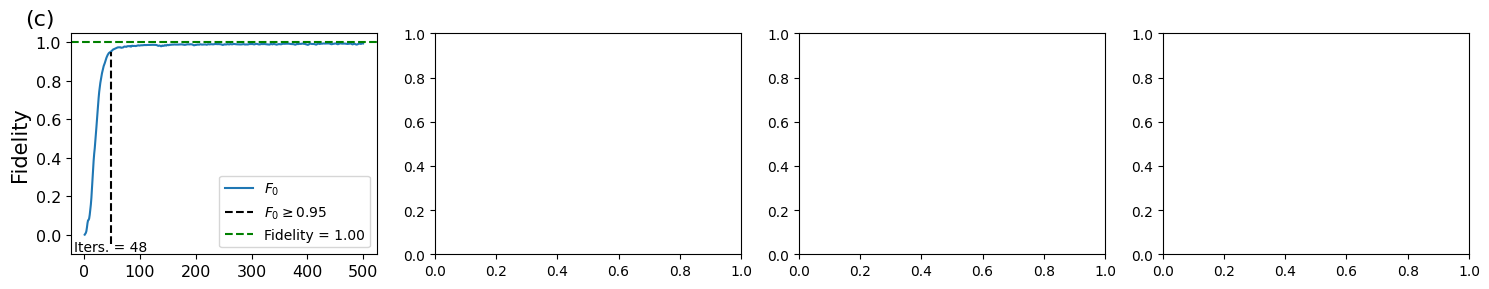

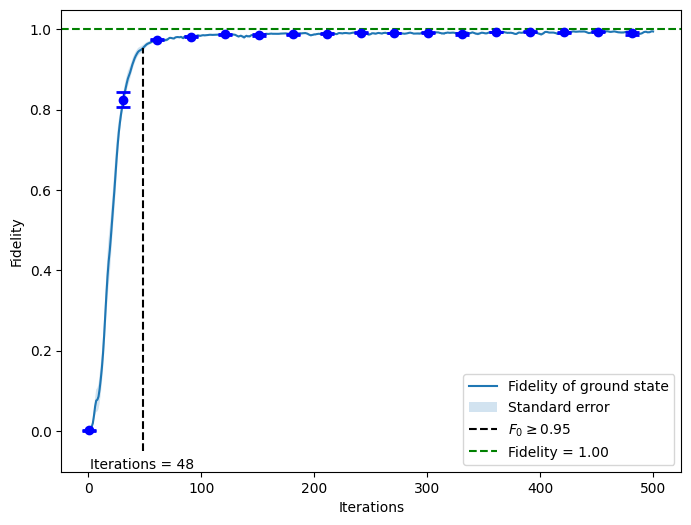

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# Define the error bar interval
error_bar_interval = 30

# The maximum number of iterations to be extracted (up to 500)
iter_max = 500

# The fidelity corresponding to the vertical dashed line
fv = 0.95

process = '2D_Hea_g'
# Read files from a specified folder on the desktop
folder_path = os.path.expanduser(f"~/Desktop/Data/Data_{process}")
files = glob.glob(f'{folder_path}/Hea_g_*')

# Dictionary for storing results
results = {}

# Read data from each file
for file in files:
    with open(file, 'r', encoding='latin-1') as f:
        for line in f:
            if "iterations:" in line:
                # Extract iteration number
                iter_num = int(line.split(',')[0].split(':')[1].strip())
                if iter_num > iter_max:
                    continue
                if iter_num not in results:
                    results[iter_num] = {}
                    
            # Extract values of NumOp_psi, Sz_psi, E, and Fidelity
            numop_match = re.search(r'NumOp_psi(\d+): ([\d.-]+)', line)
            sz_match = re.search(r'Sz_psi(\d+): ([\d.-]+)', line)
            e_match = re.search(r'E(\d+): ([\d.-]+)', line)
            fidelity_match = re.search(r'Fidelity of ground state: ([\d.-]+)', line)

            if numop_match:
                index = int(numop_match.group(1))
                value = float(numop_match.group(2))
                results[iter_num].setdefault(f'NumOp_psi{index}', []).append(value)

            if sz_match:
                index = int(sz_match.group(1))
                value = float(sz_match.group(2))
                results[iter_num].setdefault(f'Sz_psi{index}', []).append(value)

            if e_match:
                index = int(e_match.group(1))
                value = float(e_match.group(2))
                results[iter_num].setdefault(f'E{index}', []).append(value)
            
            if fidelity_match:
                fidelity_value = float(fidelity_match.group(1))
                results[iter_num].setdefault('Fidelity', []).append(fidelity_value)

# Calculate the mean and standard error
mean_std_results = {}
for iter_num, values in results.items():
    for key, val_list in values.items():
        mean_value = np.mean(val_list)
        std_error = np.std(val_list) / np.sqrt(len(val_list)) if len(val_list) > 1 else 0
        mean_std_results.setdefault(key, []).append((iter_num, mean_value, std_error))

# Find the first iteration where fidelity reaches or exceeds fv
fidelity_first_one = None
for iter_num, mean_value, _ in mean_std_results['Fidelity']:
    if mean_value >= fv:
        fidelity_first_one = iter_num
        break

# Create a figure with four subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 3))

# Add vertical line for first Fidelity = fv iteration
if fidelity_first_one is not None:
    energy_at_fidelity_one = None
    for idx in range(16):
        if f'E{idx}' in mean_std_results:
            for iter_num, mean_value, _ in mean_std_results[f'E{idx}']:
                if iter_num == fidelity_first_one:
                    energy_at_fidelity_one = mean_value
                    break
            if energy_at_fidelity_one is not None:
                break

# Fidelity plot
if 'Fidelity' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)
    lower_bound = means - errors
    upper_bound = means + errors
    
    axs[0].plot(iterations, means, linestyle='-', marker='o', markersize=0, label=r'$F_{0}$')
    #axs[0].fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
    #axs[0].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                       #yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)

    if fidelity_first_one is not None:
        axs[0].vlines(x=fidelity_first_one, ymin=axs[0].get_ylim()[0], 
                         ymax=means[np.where(iterations == fidelity_first_one)][0],
                         color='black', linestyle='--', label=rf'$F_{0}\geq{fv}$')
        axs[0].text(fidelity_first_one, axs[0].get_ylim()[0], f'Iters. = {fidelity_first_one}', 
                       color='black', ha='center', va='bottom')

axs[0].axhline(y=1.00, color='g', linestyle='--', label='Fidelity = 1.00')
axs[0].set_title('(c)', loc='left', pad=6, x=-0.15, fontsize=16)
axs[0].tick_params(axis='x', labelsize=11.5)
axs[0].tick_params(axis='y', labelsize=11.5)
#axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Fidelity', fontsize=15)
axs[0].legend()
axs[0].grid(False)

plt.tight_layout()
plt.show()

# Plot the graph: Fidelity vs Iterations and add vertical line for first Fidelity = fv
plt.figure(figsize=(8, 6))

if 'Fidelity' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)

    # Choose iterations based on the error bar interval
    sampled_iterations = iterations[::error_bar_interval]
    sampled_means = means[::error_bar_interval]
    sampled_errors = errors[::error_bar_interval]
    lower_bound = means - errors
    upper_bound = means + errors

    # Plot fidelity means and error bars
    plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label='Fidelity of ground state')
    plt.fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
    plt.errorbar(sampled_iterations, sampled_means, yerr=sampled_errors, fmt='o', color='blue',
                 capsize=5, elinewidth=1, capthick=2)

    # Add a vertical dashed line at the first Fidelity = fv iteration
    if fidelity_first_one is not None:
        fidelity_value_at_fidelity_one = means[np.where(iterations == fidelity_first_one)][0]
        plt.vlines(x=fidelity_first_one, ymin=plt.ylim()[0], ymax=fidelity_value_at_fidelity_one,
                   color='black', linestyle='--', label=rf'$F_{0}\geq{fv}$')
        plt.text(fidelity_first_one, plt.ylim()[0], f'Iterations = {fidelity_first_one}', 
                 color='black', ha='center', va='bottom')

plt.axhline(y=1.00, color='g', linestyle='--', label='Fidelity = 1.00')
#plt.title('Fidelity vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Fidelity')
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
2D_Spa_g:

<Figure size 640x480 with 0 Axes>

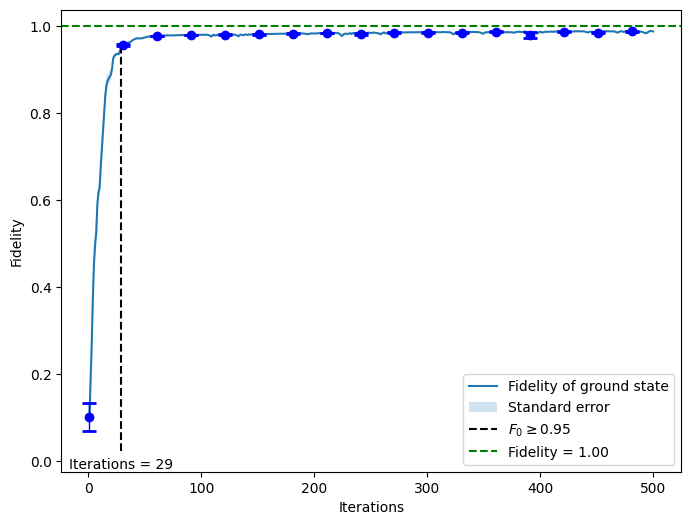

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# Define the error bar interval
error_bar_interval = 30

# The maximum number of iterations to be extracted (up to 500)
iter_max = 500

# The fidelity corresponding to the vertical dashed line
fv = 0.95

process = '2D_Spa_g'
# Read files from a specified folder on the desktop
folder_path = os.path.expanduser(f"~/Desktop/Data/Data_{process}")
files = glob.glob(f'{folder_path}/Spa_g_*')

# Dictionary for storing results
results = {}

# Read data from each file
for file in files:
    with open(file, 'r', encoding='latin-1') as f:
        for line in f:
            if "iterations:" in line:
                # Extract iteration number
                iter_num = int(line.split(',')[0].split(':')[1].strip())
                if iter_num > iter_max:
                    continue
                if iter_num not in results:
                    results[iter_num] = {}
                    
            # Extract values of NumOp_psi, Sz_psi, E, and Fidelity
            numop_match = re.search(r'NumOp_psi(\d+): ([\d.-]+)', line)
            sz_match = re.search(r'Sz_psi(\d+): ([\d.-]+)', line)
            e_match = re.search(r'E(\d+): ([\d.-]+)', line)
            fidelity_match = re.search(r'Fidelity of ground state: ([\d.-]+)', line)

            if numop_match:
                index = int(numop_match.group(1))
                value = float(numop_match.group(2))
                results[iter_num].setdefault(f'NumOp_psi{index}', []).append(value)

            if sz_match:
                index = int(sz_match.group(1))
                value = float(sz_match.group(2))
                results[iter_num].setdefault(f'Sz_psi{index}', []).append(value)

            if e_match:
                index = int(e_match.group(1))
                value = float(e_match.group(2))
                results[iter_num].setdefault(f'E{index}', []).append(value)
            
            if fidelity_match:
                fidelity_value = float(fidelity_match.group(1))
                results[iter_num].setdefault('Fidelity', []).append(fidelity_value)

# Calculate the mean and standard error
mean_std_results = {}
for iter_num, values in results.items():
    for key, val_list in values.items():
        mean_value = np.mean(val_list)
        std_error = np.std(val_list) / np.sqrt(len(val_list)) if len(val_list) > 1 else 0
        mean_std_results.setdefault(key, []).append((iter_num, mean_value, std_error))

# Find the first iteration where fidelity reaches or exceeds fv
fidelity_first_one = None
for iter_num, mean_value, _ in mean_std_results['Fidelity']:
    if mean_value >= fv:
        fidelity_first_one = iter_num
        break

# Add vertical line for first Fidelity = fv iteration
if fidelity_first_one is not None:
    energy_at_fidelity_one = None
    for idx in range(16):
        if f'E{idx}' in mean_std_results:
            for iter_num, mean_value, _ in mean_std_results[f'E{idx}']:
                if iter_num == fidelity_first_one:
                    energy_at_fidelity_one = mean_value
                    break
            if energy_at_fidelity_one is not None:
                break

# Fidelity plot
if 'Fidelity' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)
    lower_bound = means - errors
    upper_bound = means + errors
    
    axs[1].plot(iterations, means, linestyle='-', marker='o', markersize=0, label=r'$F_{0}$')
    #axs[1].fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
    #axs[1].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                       #yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)

    if fidelity_first_one is not None:
        axs[1].vlines(x=fidelity_first_one, ymin=axs[1].get_ylim()[0], 
                         ymax=means[np.where(iterations == fidelity_first_one)][0],
                         color='black', linestyle='--', label=rf'$F_{0}\geq{fv}$')
        axs[1].text(fidelity_first_one + 25, axs[1].get_ylim()[0], f'Iters. = {fidelity_first_one}', 
                       color='black', ha='center', va='bottom')

axs[1].axhline(y=1.00, color='g', linestyle='--', label='Fidelity = 1.00')
axs[1].set_title('(d)', loc='left', pad=6, x=-0.15, fontsize=16)
axs[1].tick_params(axis='x', labelsize=11.5)
axs[1].tick_params(axis='y', labelsize=11.5)
#axs[1].set_xlabel('Iterations')
#axs[1].set_ylabel('Fidelity', fontsize=15)
axs[1].legend()
axs[1].grid(False)

plt.tight_layout()
plt.show()

# Plot the graph: Fidelity vs Iterations and add vertical line for first Fidelity = fv
plt.figure(figsize=(8, 6))

if 'Fidelity' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)

    # Choose iterations based on the error bar interval
    sampled_iterations = iterations[::error_bar_interval]
    sampled_means = means[::error_bar_interval]
    sampled_errors = errors[::error_bar_interval]
    lower_bound = means - errors
    upper_bound = means + errors

    # Plot fidelity means and error bars
    plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label='Fidelity of ground state')
    plt.fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
    plt.errorbar(sampled_iterations, sampled_means, yerr=sampled_errors, fmt='o', color='blue',
                 capsize=5, elinewidth=1, capthick=2)

    # Add a vertical dashed line at the first Fidelity = fv iteration
    if fidelity_first_one is not None:
        fidelity_value_at_fidelity_one = means[np.where(iterations == fidelity_first_one)][0]
        plt.vlines(x=fidelity_first_one, ymin=plt.ylim()[0], ymax=fidelity_value_at_fidelity_one,
                   color='black', linestyle='--', label=rf'$F_{0}\geq{fv}$')
        plt.text(fidelity_first_one, plt.ylim()[0], f'Iterations = {fidelity_first_one}', 
                 color='black', ha='center', va='bottom')

plt.axhline(y=1.00, color='g', linestyle='--', label='Fidelity = 1.00')
#plt.title('Fidelity vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Fidelity')
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
2D_Hea_e2:

<Figure size 640x480 with 0 Axes>

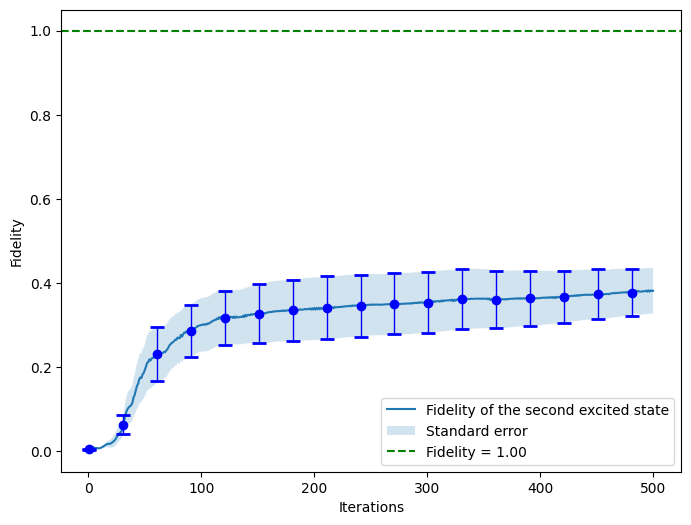

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# Define the error bar interval
error_bar_interval = 30

# The maximum number of iterations to be extracted (up to 500)
iter_max = 500

# The fidelity corresponding to the vertical dashed line
fv = 0.95

process = '2D_Hea_ae'
# Read files from a specified folder on the desktop
folder_path = os.path.expanduser(f"~/Desktop/Data/Data_{process}")
files = glob.glob(f'{folder_path}/Hea_ae_*')

# Dictionary for storing results
results = {}

# Read data from each file
for file in files:
    with open(file, 'r', encoding='latin-1') as f:
        for line in f:
            if "iterations:" in line:
                # Extract iteration number
                iter_num = int(line.split(',')[0].split(':')[1].strip())
                if iter_num > iter_max:
                    continue
                if iter_num not in results:
                    results[iter_num] = {}
                    
            # Extract values of NumOp_psi, Sz_psi, E, and Fidelity
            numop_match = re.search(r'NumOp_psi(\d+): ([\d.-]+)', line)
            sz_match = re.search(r'Sz_psi(\d+): ([\d.-]+)', line)
            e_match = re.search(r'E(\d+): ([\d.-]+)', line)
            fidelity_match = re.search(r'Fidelity of excited state 5: ([\d.-]+)', line)

            if numop_match:
                index = int(numop_match.group(1))
                value = float(numop_match.group(2))
                results[iter_num].setdefault(f'NumOp_psi{index}', []).append(value)

            if sz_match:
                index = int(sz_match.group(1))
                value = float(sz_match.group(2))
                results[iter_num].setdefault(f'Sz_psi{index}', []).append(value)

            if e_match:
                index = int(e_match.group(1))
                value = float(e_match.group(2))
                results[iter_num].setdefault(f'E{index}', []).append(value)
            
            if fidelity_match:
                fidelity_value = float(fidelity_match.group(1))
                results[iter_num].setdefault('Fidelity', []).append(fidelity_value)

# Calculate the mean and standard error
mean_std_results = {}
for iter_num, values in results.items():
    for key, val_list in values.items():
        mean_value = np.mean(val_list)
        std_error = np.std(val_list) / np.sqrt(len(val_list)) if len(val_list) > 1 else 0
        mean_std_results.setdefault(key, []).append((iter_num, mean_value, std_error))

# Find the first iteration where fidelity reaches or exceeds fv
fidelity_first_one = None
for iter_num, mean_value, _ in mean_std_results['Fidelity']:
    if mean_value >= fv:
        fidelity_first_one = iter_num
        break

# Add vertical line for first Fidelity = fv iteration
if fidelity_first_one is not None:
    energy_at_fidelity_one = None
    for idx in range(16):
        if f'E{idx}' in mean_std_results:
            for iter_num, mean_value, _ in mean_std_results[f'E{idx}']:
                if iter_num == fidelity_first_one:
                    energy_at_fidelity_one = mean_value
                    break
            if energy_at_fidelity_one is not None:
                break

# Fidelity plot
if 'Fidelity' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)
    lower_bound = means - errors
    upper_bound = means + errors
    
    axs[2].plot(iterations, means, linestyle='-', marker='o', markersize=0, label=r'$F_{1}$')
    #axs[2].fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
    #axs[2].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                       #yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)

    if fidelity_first_one is not None:
        axs[2].vlines(x=fidelity_first_one, ymin=axs[2].get_ylim()[0], 
                         ymax=means[np.where(iterations == fidelity_first_one)][0],
                         color='black', linestyle='--', label=rf'$F_{{1}}\geq{fv}$')
        axs[2].text(fidelity_first_one + 25, axs[2].get_ylim()[0], f'Iters. = {fidelity_first_one}', 
                       color='black', ha='center', va='bottom')

axs[2].axhline(y=1.00, color='g', linestyle='--', label='Fidelity = 1.00')
axs[2].set_title('(e)', loc='left', pad=6, x=-0.15, fontsize=16)
axs[2].tick_params(axis='x', labelsize=11.5)
axs[2].tick_params(axis='y', labelsize=11.5)
#axs[2].set_xlabel('Iterations')
#axs[2].set_ylabel('Fidelity', fontsize=15)
axs[2].legend()
axs[2].grid(False)

plt.tight_layout()
plt.show()

# Plot the graph: Fidelity vs Iterations and add vertical line for first Fidelity = fv
plt.figure(figsize=(8, 6))

if 'Fidelity' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)

    # Choose iterations based on the error bar interval
    sampled_iterations = iterations[::error_bar_interval]
    sampled_means = means[::error_bar_interval]
    sampled_errors = errors[::error_bar_interval]
    lower_bound = means - errors
    upper_bound = means + errors

    # Plot fidelity means and error bars
    plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label='Fidelity of the second excited state')
    plt.fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
    plt.errorbar(sampled_iterations, sampled_means, yerr=sampled_errors, fmt='o', color='blue',
                 capsize=5, elinewidth=1, capthick=2)

    # Add a vertical dashed line at the first Fidelity = fv iteration
    if fidelity_first_one is not None:
        fidelity_value_at_fidelity_one = means[np.where(iterations == fidelity_first_one)][0]
        plt.vlines(x=fidelity_first_one, ymin=plt.ylim()[0], ymax=fidelity_value_at_fidelity_one,
                   color='black', linestyle='--', label=rf'$F_{{1}}\geq{fv}$')
        plt.text(fidelity_first_one, plt.ylim()[0], f'Iterations = {fidelity_first_one}', 
                 color='black', ha='center', va='bottom')

plt.axhline(y=1.00, color='g', linestyle='--', label='Fidelity = 1.00')
#plt.title('Fidelity vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Fidelity')
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
2D_Spa_en4:

<Figure size 640x480 with 0 Axes>

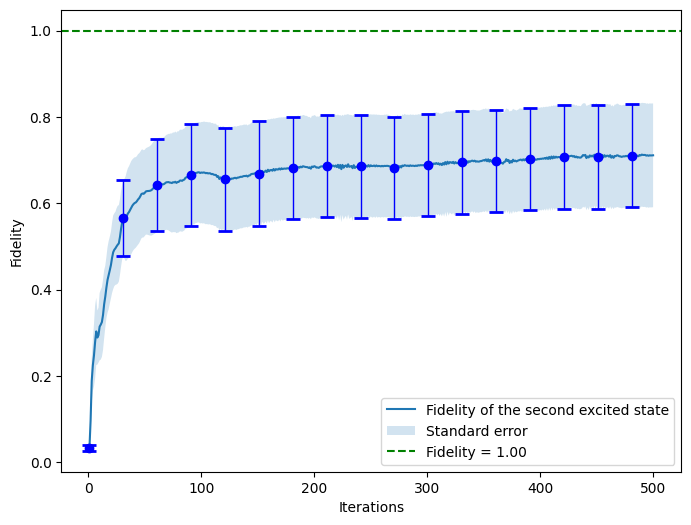

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re

# Define the error bar interval
error_bar_interval = 30

# The maximum number of iterations to be extracted (up to 500)
iter_max = 500

# The fidelity corresponding to the vertical dashed line
fv = 0.95

process = '2D_Spa_en4'
# Read files from a specified folder on the desktop
folder_path = os.path.expanduser(f"~/Desktop/Data/Data_{process}")
files = glob.glob(f'{folder_path}/Spa_en4_*')

# Dictionary for storing results
results = {}

# Read data from each file
for file in files:
    with open(file, 'r', encoding='latin-1') as f:
        for line in f:
            if "iterations:" in line:
                # Extract iteration number
                iter_num = int(line.split(',')[0].split(':')[1].strip())
                if iter_num > iter_max:
                    continue
                if iter_num not in results:
                    results[iter_num] = {}
                    
            # Extract values of NumOp_psi, Sz_psi, E, and Fidelity
            numop_match = re.search(r'NumOp_psi(\d+): ([\d.-]+)', line)
            sz_match = re.search(r'Sz_psi(\d+): ([\d.-]+)', line)
            e_match = re.search(r'E(\d+): ([\d.-]+)', line)
            fidelity_match = re.search(r'Fidelity of excited state 5: ([\d.-]+)', line)

            if numop_match:
                index = int(numop_match.group(1))
                value = float(numop_match.group(2))
                results[iter_num].setdefault(f'NumOp_psi{index}', []).append(value)

            if sz_match:
                index = int(sz_match.group(1))
                value = float(sz_match.group(2))
                results[iter_num].setdefault(f'Sz_psi{index}', []).append(value)

            if e_match:
                index = int(e_match.group(1))
                value = float(e_match.group(2))
                results[iter_num].setdefault(f'E{index}', []).append(value)
            
            if fidelity_match:
                fidelity_value = float(fidelity_match.group(1))
                results[iter_num].setdefault('Fidelity', []).append(fidelity_value)

# Calculate the mean and standard error
mean_std_results = {}
for iter_num, values in results.items():
    for key, val_list in values.items():
        mean_value = np.mean(val_list)
        std_error = np.std(val_list) / np.sqrt(len(val_list)) if len(val_list) > 1 else 0
        mean_std_results.setdefault(key, []).append((iter_num, mean_value, std_error))

# Find the first iteration where fidelity reaches or exceeds fv
fidelity_first_one = None
for iter_num, mean_value, _ in mean_std_results['Fidelity']:
    if mean_value >= fv:
        fidelity_first_one = iter_num
        break

# Add vertical line for first Fidelity = fv iteration
if fidelity_first_one is not None:
    energy_at_fidelity_one = None
    for idx in range(16):
        if f'E{idx}' in mean_std_results:
            for iter_num, mean_value, _ in mean_std_results[f'E{idx}']:
                if iter_num == fidelity_first_one:
                    energy_at_fidelity_one = mean_value
                    break
            if energy_at_fidelity_one is not None:
                break

# Fidelity plot
if 'Fidelity' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)
    lower_bound = means - errors
    upper_bound = means + errors
    
    axs[3].plot(iterations, means, linestyle='-', marker='o', markersize=0, label=r'$F_{1}$')
    #axs[3].fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
    #axs[3].errorbar(iterations[::error_bar_interval], means[::error_bar_interval], 
                       #yerr=errors[::error_bar_interval], fmt='o', color='blue', capsize=5)

    if fidelity_first_one is not None:
        axs[3].vlines(x=fidelity_first_one, ymin=axs[3].get_ylim()[0], 
                         ymax=means[np.where(iterations == fidelity_first_one)][0],
                         color='black', linestyle='--', label=rf'$F_{{1}}\geq{fv}$')
        axs[3].text(fidelity_first_one + 25, axs[3].get_ylim()[0], f'Iters. = {fidelity_first_one}', 
                       color='black', ha='center', va='bottom')

axs[3].axhline(y=1.00, color='g', linestyle='--', label='Fidelity = 1.00')
axs[3].set_title('(f)', loc='left', pad=6, x=-0.15, fontsize=16)
axs[3].tick_params(axis='x', labelsize=11.5)
axs[3].tick_params(axis='y', labelsize=11.5)
#axs[3].set_xlabel('Iterations')
#axs[3].set_ylabel('Fidelity', fontsize=15)
axs[3].legend()
axs[3].grid(False)

plt.tight_layout()
fig.subplots_adjust(wspace=0.2)
save_dir = os.path.expanduser('~/Desktop/Picture')
os.makedirs(save_dir, exist_ok=True)

#fig_save_path = os.path.join(save_dir, f"{process}_4.pdf")
#fig.savefig(fig_save_path, format='pdf', dpi=300)

fig.text(0.5, 0.0, 'Iterations', ha='center', va='top', fontsize=16.5)
fig_save_path = os.path.join(save_dir, f'2D_g_and_e2.pdf')
fig.savefig(fig_save_path, format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Plot the graph: Fidelity vs Iterations and add vertical line for first Fidelity = fv
plt.figure(figsize=(8, 6))

if 'Fidelity' in mean_std_results:
    iterations, means, errors = zip(*mean_std_results['Fidelity'])
    iterations = np.array(iterations)
    means = np.array(means)
    errors = np.array(errors)

    # Choose iterations based on the error bar interval
    sampled_iterations = iterations[::error_bar_interval]
    sampled_means = means[::error_bar_interval]
    sampled_errors = errors[::error_bar_interval]
    lower_bound = means - errors
    upper_bound = means + errors

    # Plot fidelity means and error bars
    plt.plot(iterations, means, linestyle='-', marker='o', markersize=0, label='Fidelity of the second excited state')
    plt.fill_between(iterations, lower_bound, upper_bound, alpha=0.2, label='Standard error')
    plt.errorbar(sampled_iterations, sampled_means, yerr=sampled_errors, fmt='o', color='blue',
                 capsize=5, elinewidth=1, capthick=2)

    # Add a vertical dashed line at the first Fidelity = fv iteration
    if fidelity_first_one is not None:
        fidelity_value_at_fidelity_one = means[np.where(iterations == fidelity_first_one)][0]
        plt.vlines(x=fidelity_first_one, ymin=plt.ylim()[0], ymax=fidelity_value_at_fidelity_one,
                   color='black', linestyle='--', label=rf'$F_{{1}}\geq{fv}$')
        plt.text(fidelity_first_one, plt.ylim()[0], f'Iterations = {fidelity_first_one}', 
                 color='black', ha='center', va='bottom')

plt.axhline(y=1.00, color='g', linestyle='--', label='Fidelity = 1.00')
#plt.title('Fidelity vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Fidelity')
plt.legend()
plt.grid(False)
plt.show()
